In [565]:
from _py.config import config
import numpy as np, pandas as pd
import warnings; warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.base import BaseEstimator, TransformerMixin, clone
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, roc_auc_score

import lightgbm as lgbm
import xgboost as xgb

from scipy.stats import wasserstein_distance
from sklearn.cluster import KMeans
from scipy.stats import ks_2samp

from sklearn.inspection import permutation_importance

In [13]:
train = pd.read_sql('SELECT * FROM train ORDER BY id', config.engine, index_col='id')
test = pd.read_sql('SELECT * FROM test ORDER BY id', config.engine, index_col='id')
orig = pd.read_sql('SELECT * FROM orig', config.engine)

target = train[config.target_name]
train = train.drop(config.target_name, axis=1)

BASE = train.columns.to_list()
NUM = train.select_dtypes(include='number').columns.to_list()
CAT = train.select_dtypes(include=['object', 'category']).columns.to_list()

In [26]:
print(f'id matching train: {train.index.is_monotonic_increasing}')    
print(f'id matching test: {test.index.is_monotonic_increasing}')    

id matching train: True
id matching test: True


# Drift Analysis

In [453]:
class CategoricalTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, cat_features=None):
        self.cat_features = cat_features
        
    def fit(self, X, y=None):
        if self.cat_features is None:
            self.cat_features_ = X.select_dtypes(include=['object', 'bool']).columns.tolist()
        else:
            self.cat_features_ = list(self.cat_features)
            
        return self       
    def transform(self, X):
        self.fit(X)
        X_out = X.copy()
        for col in self.cat_features_:
            if col in X_out.columns:
                X_out[col] = X_out[col].astype('category')

        return X_out

In [27]:
def concat_domains(X_1, X_2):
    domain_1 = X_1.copy()
    domain_1['flag'] = 0
    
    domain_2 = X_2.copy()
    domain_2['flag'] = 1

    df_concated = pd.concat((domain_1, domain_2))
    
    flag = df_concated['flag']
    df_concated = df_concated.drop('flag', axis=1)
    return df_concated, flag

In [37]:
def get_drift(X, y):
    skf = StratifiedKFold(n_splits=5, shuffle=True)
    auc_scores = []
    for fold, (train_idx, valid_idx) in enumerate(skf.split(X, y)):
        X_train, X_valid = X.iloc[train_idx].copy(), X.iloc[valid_idx].copy()
        y_train, y_valid = y.iloc[train_idx], y.iloc[valid_idx]

        ct = CategoricalTransformer()
        X_train, X_valid = ct.fit_transform(X_train), ct.transform(X_valid)
        
        model = lgbm.LGBMClassifier(verbose=-1, n_estimators=100, device='gpu')
        model.fit(X_train, y_train)
        proba = model.predict_proba(X_valid)[:, 1]
        score = roc_auc_score(y_valid, proba)
        auc_scores.append(score)
    mean_auc = np.mean(auc_scores)

    return mean_auc

In [44]:
df_concated, is_test_flag = concat_domains(train, test)
for name, features in dict(zip(['BASE', 'NUM', 'CAT'], [BASE, NUM, CAT])).items():
    drift_auc = get_drift(df_concated[features], is_test_flag)
    print(f'drift OOF-AUC over {name} features: {drift_auc:.5f}')

drift OOF-AUC over BASE features: 0.62766
drift OOF-AUC over NUM features: 0.62708
drift OOF-AUC over CAT features: 0.51575


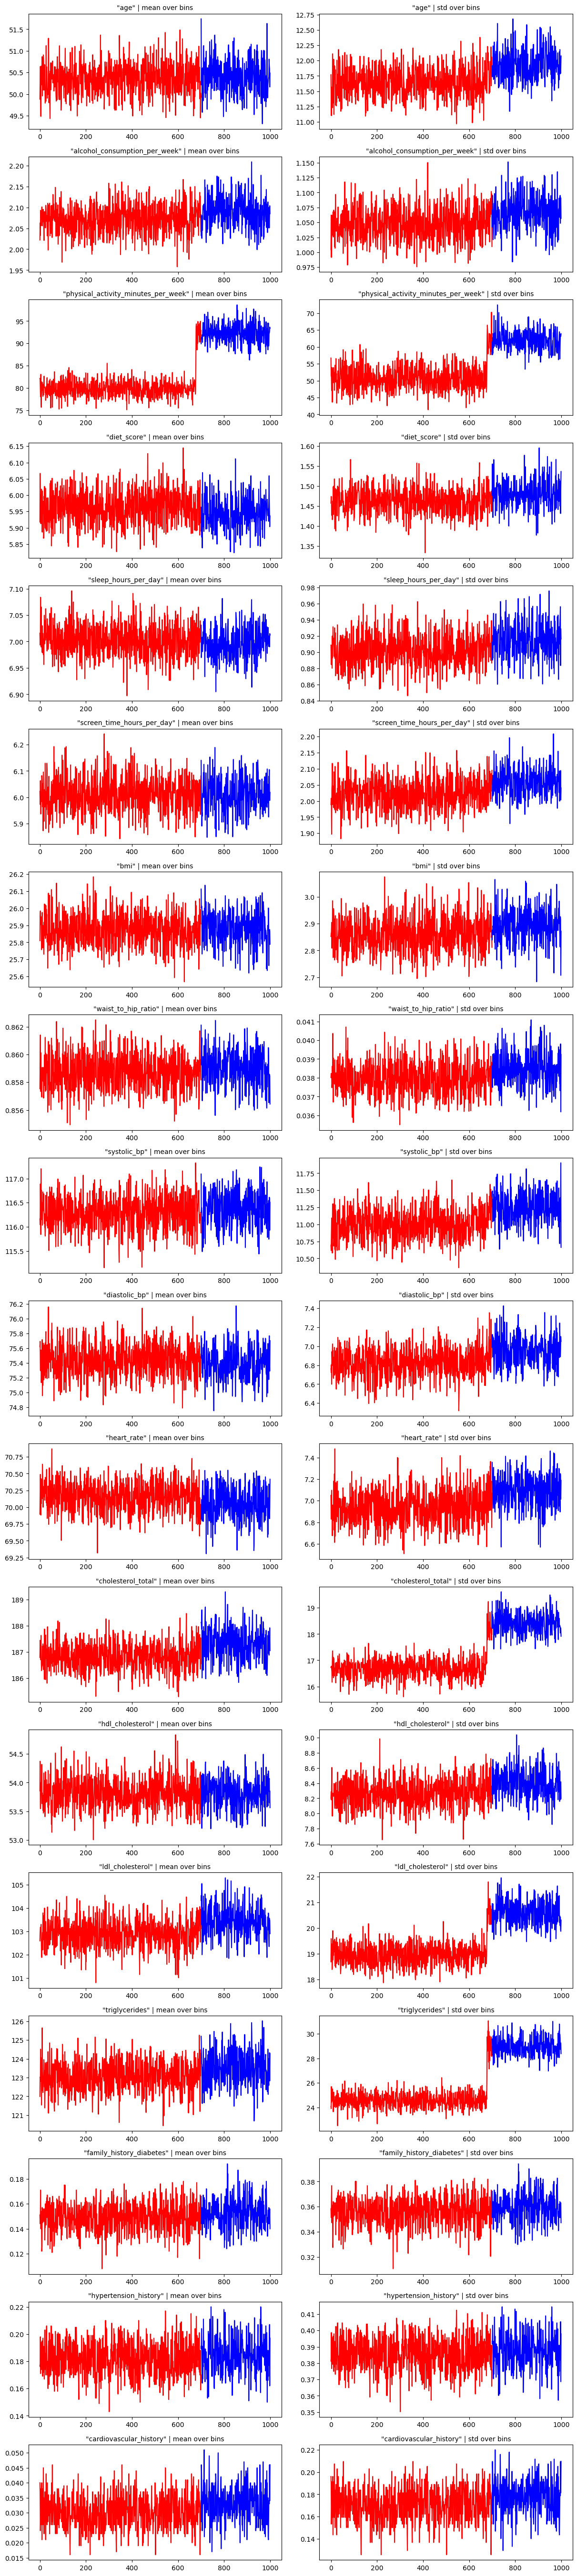

In [298]:
train_bins = train.shape[0]//1000
test_bins = test.shape[0]//1000
train['id_bins'] = pd.cut(train.index, bins=train_bins, labels=np.arange(0, train_bins, 1), include_lowest=True)
test['id_bins'] = pd.cut(test.index, bins=test_bins, labels=np.arange(train_bins, train_bins+test_bins, 1), include_lowest=True)

length = len(NUM)

fig, axes = plt.subplots(length, 2,
                        figsize=(12, length*3),
                        gridspec_kw={'height_ratios': [1] * length,
                                     'wspace': 0.05,
                                     'hspace': 0.05,
                                     'width_ratios': [0.5, 0.5]},
                         constrained_layout=True)
for i, col in enumerate(NUM):
    ax = axes[i, 0]
    ax.plot(train.groupby('id_bins', observed=False)[col].mean(), color='red')
    ax.plot(test.groupby('id_bins', observed=False)[col].mean(), color='blue')
    ax.set_title(f'"{col}" | mean over bins', size=10)
    ax = axes[i, 1]
    ax.plot(train.groupby('id_bins', observed=False)[col].std(), color='red')
    ax.plot(test.groupby('id_bins', observed=False)[col].std(), color='blue')
    ax.set_title(f'"{col}" | std over bins', size=10)
plt.show()

## Kolmogorov-Smirnov

In [165]:
ks_over_bins = pd.Series()
for i in range(train['id_bins'].max()+1):
    ks_over_bins[i] = ks_2samp(train[train['id_bins']==i]['physical_activity_minutes_per_week'], test['physical_activity_minutes_per_week']).pvalue>=0.05

In [174]:
train['id_bins'].map(ks_over_bins).values

array([False, False, False, ...,  True,  True,  True])

In [177]:
ks_over_bins[ks_over_bins].index

Index([678, 679, 680, 681, 682, 683, 684, 685, 687, 688, 689, 690, 691, 692,
       693, 694, 695, 696, 697, 698, 699],
      dtype='int64')

## Wasserstein distances

In [178]:
wass_distances = pd.DataFrame()
for col in NUM:
    for i in range(700):
        wass_distances.loc[i, col] = wasserstein_distance( train[train['id_bins']==i][col], test[col])

In [187]:
kmeans = KMeans(n_clusters=2, random_state=5)
kmeans.fit(wass_distances)

KMeans(n_clusters=2, random_state=5)

In [224]:
wass_distances.index[kmeans.labels_.astype(bool)]

Index([678, 679, 680, 681, 682, 683, 684, 685, 686, 687, 688, 689, 690, 691,
       692, 693, 694, 695, 696, 697, 698, 699],
      dtype='int64')

In [251]:
bin_mask = pd.Series(kmeans.labels_.astype(bool))
id_mask = train['id_bins'].map(bin_mask)

valid_idx = train[id_mask].index.values
train_idx = train[~id_mask].index.values

In [252]:
train_idx.shape, valid_idx.shape

((678000,), (22000,))

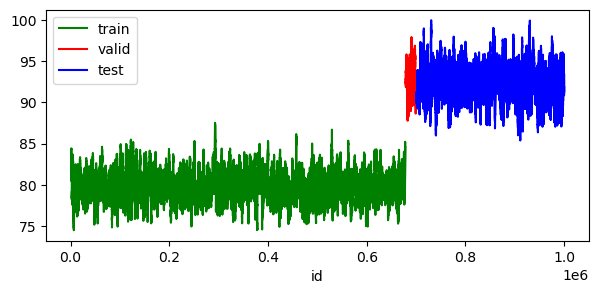

In [286]:
plt.figure(figsize=(7, 3))
train.iloc[train_idx]['physical_activity_minutes_per_week'].rolling(1000).mean().plot(label='train', color='green')

train.iloc[valid_idx]['physical_activity_minutes_per_week'].rolling(1000).mean().plot(label='valid', color='red')
test['physical_activity_minutes_per_week'].rolling(1000).mean().plot(label='test', color='blue')
plt.legend()
plt.show()

In [301]:
# Веса для сэмпла для рефита модели
w = len(train_idx) / len(valid_idx)
weights = np.ones(train.shape[0])
weights[valid_idx] = w # 30.81

# Baseline

In [530]:
y_train, y_valid = target.iloc[train_idx], target.iloc[valid_idx]

# train = train.drop('id_bins', axis=1)
X_train, X_valid = train.iloc[train_idx].copy(), train.iloc[valid_idx].copy()

In [570]:
model = \
xgb.XGBClassifier(
    device='gpu',
    objective='binary:logistic',
    tree_method = 'hist',
    eval_metric='auc',
    enable_categorical=True,
    seed=10+i,
    
    n_estimators=500,
    early_stopping_rounds=100,
    learning_rate=0.05,
    
    subsample = 1,
    colsample_bytree=1,
)
def train_baseline(model, X_train, y_train, X_valid, y_valid):
    ct = CategoricalTransformer()
    X_tr, X_val = ct.fit_transform(X_train), ct.transform(X_valid)

    scores = []
    for i in range(5):
        model_ = clone(model)
        model_.fit(X_tr, y_train, eval_set=[(X_val, y_valid)], verbose=0)
        scores.append(model_.best_score)
    return np.mean(scores)

In [571]:
print(f'BASE FEATURES || MEAN AUC-SCORE: {train_baseline(model, X_train, y_train, X_valid, y_valid):.5f}')

BASE FEATURES || MEAN AUC-SCORE: 0.69463


# Data Analysis

## Visualization

## Feature enginering

### orig features

In [559]:
def create_orig_features(X, cols, verbose=True):
    X_out = X.copy()
    new_features = []
    
    for col in cols:
        # MEAN FEATURES
        new_feature = f"orig_mean_{col}"
        mean_map = orig.groupby(col)[config.target_name].mean()
        mean_map.name = new_feature
        new_features.append(new_feature)
        X_out = X_out.merge(mean_map, on=col, how='left')
        
        # COUNT FEATURES
        new_feature = f"orig_count_{col}"
        count_map = orig.groupby(col)[config.target_name].count()
        count_map.name = new_feature
        new_features.append(new_feature)
        X_out = X_out.merge(count_map, on=col, how='left')
        
    for col in new_features:
        if 'mean' in col:
            X_out[col] = X_out[col].fillna(orig[config.target_name].mean())
        else:
            X_out[col] = X_out[col].fillna(0)
            
    if verbose:   
        print(f'{len(new_features)} new features based on orig dataset created')
    return X_out, new_features

In [566]:
# Аггрегации по категориальным
train_eng, orig_features = create_orig_features(train, CAT)

X_train, X_valid = train_eng.iloc[train_idx].copy(), train_eng.iloc[valid_idx].copy()
y_train, y_valid = target.iloc[train_idx], target.iloc[valid_idx]

print(f'BASE + CAT ORIG-FEATURES || MEAN AUC-SCORE: {train_baseline(X_train, y_train, X_valid, y_valid):.5f}')

12 new features based on orig dataset created
BASE + CAT ORIG-FEATURES || MEAN AUC-SCORE: 0.69463


In [560]:
train_eng, orig_features = create_orig_features(train, BASE)

X_train, X_valid = train_eng.iloc[train_idx].copy(), train_eng.iloc[valid_idx].copy()
y_train, y_valid = target.iloc[train_idx], target.iloc[valid_idx]

# all features
print(f'BASE + ALL ORIG-FEATURES || MEAN AUC-SCORE: {train_baseline(X_train, y_train, X_valid, y_valid):.5f}')
# only orig
print(f'ONLY ORIG-FEATURES || MEAN AUC-SCORE: {train_baseline(X_train[orig_features], y_train, X_valid[orig_features], y_valid):.5f}')

48 new features based on orig dataset created
BASE + ALL ORIG-FEATURES || MEAN AUC-SCORE: 0.69978
ONLY ORIG-FEATURES || MEAN AUC-SCORE: 0.69973


In [561]:
all_features = BASE + orig_features

### corr interactions

In [562]:
import re
from itertools import combinations

In [563]:
def create_interactions(X):
    X_out = X.copy()
    cholesterols = [col for col in all_features if re.search(r'cholesterol', col)]
    new_features = []
    for col1, col2 in list(combinations(cholesterols, 2)):
        feature_name = f'multiply_{col1}_{col2}'
        X_out[feature_name] = X_out[col1]*X_out[col2]
        new_features.append(feature_name)
        
        feature_name = f'div_{col1}_{col2}'
        X_out[feature_name] = X_out[col1] / (X_out[col2]+1e-6)
        new_features.append(feature_name)
        
    return X_out, new_features

In [564]:
train_inter, inter_features = create_interactions(train_eng)
X_train, X_valid = train_inter.iloc[train_idx].copy(), train_inter.iloc[valid_idx].copy()

print(f'INTERACTIONS + ONLY ORIG-FEATURES || MEAN AUC-SCORE: {
train_baseline(X_train[orig_features+inter_features], y_train, X_valid[orig_features+inter_features], y_valid):.5f}')

INTERACTIONS + ONLY ORIG-FEATURES || MEAN AUC-SCORE: 0.69960


## Importances

### mutual_information

### permutation

In [ ]:
result = permutation_importance(model_lgbm, X_valid, y_valid, n_repeats=10, scoring='roc_auc')